In [6]:
from eo_stack import *

In [7]:
s2 = S2TempStack(os.environ['WIN_SVR_DATA']+'Saldana_training_2015/pre/',
                 os.environ['WIN_SVR_DATA']+'Saldana_training_2015/pre/stack/')

S2 object initialized from /mnt/workspace_cluster_6/TRANSVERSAL_PROJECTS/MADR/COMPONENTE_2/Imagenes_Satelitales/Temp/asalazar_tests/data/Saldana_training_2015/pre/


In [8]:
s2_xds = s2.getXDataset()

In [9]:
s2_xds

<xarray.Dataset>
Dimensions:   (time: 9, x: 2979, y: 3631)
Coordinates:
  * x         (x) float64 4.889e+05 4.889e+05 4.889e+05 4.889e+05 4.889e+05 ...
    band      int64 ...
  * y         (y) float64 4.485e+05 4.484e+05 4.484e+05 4.484e+05 4.484e+05 ...
  * time      (time) datetime64[ns] 2015-12-21 2015-12-31 2016-01-10 ...
    mask      (time, y, x) bool dask.array<shape=(9, 3631, 2979), chunksize=(1, 3631, 2979)>
Data variables:
    blue      (time, y, x) float64 dask.array<shape=(9, 3631, 2979), chunksize=(1, 3631, 2979)>
    swir1     (time, y, x) float64 dask.array<shape=(9, 3631, 2979), chunksize=(1, 3631, 2979)>
    swir2     (time, y, x) float64 dask.array<shape=(9, 3631, 2979), chunksize=(1, 3631, 2979)>
    qa_class  (time, y, x) float64 dask.array<shape=(9, 3631, 2979), chunksize=(1, 3631, 2979)>
    qa_cloud  (time, y, x) float64 dask.array<shape=(9, 3631, 2979), chunksize=(1, 3631, 2979)>
    green     (time, y, x) float64 dask.array<shape=(9, 3631, 2979), chunksize=(1,

In [14]:
ndvi = s2_xds.isel(time=0).NDVI

In [29]:
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
import matplotlib.pyplot as plt
import numpy as np

In [18]:
subset = s2_xds.isel(time=0, x=slice(2000, 2500), y=slice(800, 1600))
subset

<xarray.Dataset>
Dimensions:   (x: 500, y: 800)
Coordinates:
  * x         (x) float64 5.089e+05 5.089e+05 5.089e+05 5.089e+05 5.089e+05 ...
    band      int64 ...
  * y         (y) float64 4.405e+05 4.404e+05 4.404e+05 4.404e+05 4.404e+05 ...
    time      datetime64[ns] 2015-12-21
    mask      (y, x) bool dask.array<shape=(800, 500), chunksize=(800, 500)>
Data variables:
    blue      (y, x) float64 dask.array<shape=(800, 500), chunksize=(800, 500)>
    swir1     (y, x) float64 dask.array<shape=(800, 500), chunksize=(800, 500)>
    swir2     (y, x) float64 dask.array<shape=(800, 500), chunksize=(800, 500)>
    qa_class  (y, x) float64 dask.array<shape=(800, 500), chunksize=(800, 500)>
    qa_cloud  (y, x) float64 dask.array<shape=(800, 500), chunksize=(800, 500)>
    green     (y, x) float64 dask.array<shape=(800, 500), chunksize=(800, 500)>
    nir       (y, x) float64 dask.array<shape=(800, 500), chunksize=(800, 500)>
    NDVI      (y, x) float32 dask.array<shape=(800, 500), chun

In [33]:
# Get the rgb image for slic segmentation
rgb = subset.to_array().sel(variable=['red','green','blue']).transpose('x','y','variable').data
print('RGB shape: {}'.format(rgb.shape))
# Get the NDVI mask to use in watershed segmentation
ndvi = subset.NDVI.transpose('x','y').data
print('NDVI shape: {}'.format(ndvi.shape))

image = img_as_float(rgb/10000)

RGB shape: (500, 800, 3)
NDVI shape: (500, 800)


In [134]:
# Calculation of number of segments (empirically)
num_segments = (ndvi.shape[0] * ndvi.shape[1])/100

In [135]:
segments_slic = slic(img_as_float(rgb/10000), n_segments=num_segments, compactness=3)
segments_watershed = watershed(sobel(ndvi), markers=num_segments, compactness=0.001)

SLIC number of segments: 3211
Compact Watershed number of segments: 4000


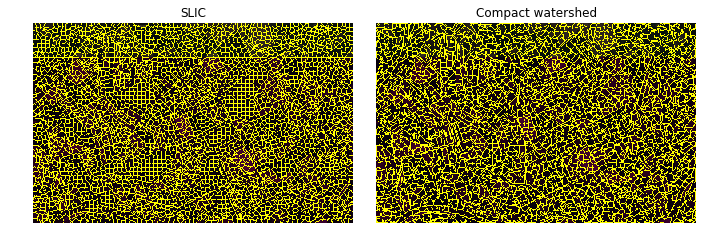

In [136]:
#http://scikit-image.org/docs/dev/auto_examples/segmentation/plot_segmentations.html
print('SLIC number of segments: {}'.format(len(np.unique(segments_slic))))
print('Compact Watershed number of segments: {}'.format(len(np.unique(segments_watershed))))

fig, ax = plt.subplots(1, 2, figsize=(10, 10), sharex=True, sharey=True)

ax[0].imshow(mark_boundaries(image, segments_slic))
ax[0].set_title('SLIC')
ax[1].imshow(mark_boundaries(image, segments_watershed))
ax[1].set_title('Compact watershed')

for a in ax.ravel():
    a.set_axis_off()

plt.tight_layout()
plt.show()

In [126]:
s1 = S1TempStack(os.environ['WIN_SVR_DATA']+'Saldana_training_2015/pre/DESCENDING/',
                 os.environ['WIN_SVR_DATA']+'Saldana_training_2015/pre/DESCENDING/')
s1_xds = s1.getXDataset()
radar_subset = s1_xds.isel(time=0, x=slice(2000, 2500), y=slice(800, 1600))

S1 object initialized from /mnt/workspace_cluster_6/TRANSVERSAL_PROJECTS/MADR/COMPONENTE_2/Imagenes_Satelitales/Temp/asalazar_tests/data/Saldana_training_2015/pre/DESCENDING/


In [137]:
# Create dummy array to compute stats
darray = np.array(radar_subset.VV.transpose('x','y').data.copy())
# New array for the zonal stats
stats_watershed = np.zeros((500, 800), dtype=float)
# Iterate over segments, compute and assign stat value to pixels in each segment
for segment in np.unique(segments_watershed):
    masked = np.ma.MaskedArray(darray, mask=np.logical_not(segments_watershed==segment))
    np.place(stats_watershed, segments_watershed==segment, masked.mean())

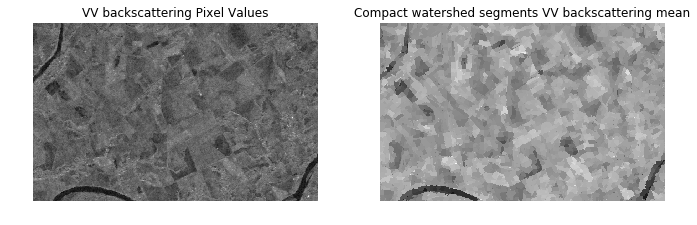

In [138]:
# Visualize results
fig, ax = plt.subplots(1, 2, figsize=(10, 10), sharex=True, sharey=True)
ax[0].imshow(darray, cmap='gray')
ax[0].set_title('VV backscattering Pixel Values')
ax[1].imshow(stats_watershed, cmap='gray')
ax[1].set_title('Compact watershed segments VV backscattering mean')
for a in ax.ravel():
    a.set_axis_off()
plt.tight_layout()
plt.show()